# Multi-label prediction with Planet Amazon dataset

<table align="left"><td>
  <a target="_blank"  href="https://colab.research.google.com/github/TannerGilbert/FastAI-Code-Collection/blob/v1/Multi_label_prediction_with_Planet_Amazon_dataset.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab
  </a>
</td><td>
  <a target="_blank"  href="https://github.com/TannerGilbert/FastAI-Code-Collection/blob/v1/Multi_label_prediction_with_Planet_Amazon_datase">
    <img width=32px src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
</td></table>

In [ ]:
!pip install fastai==1.0.61

In [ ]:
from fastai.vision import *

## Get data

In [ ]:
# Install Kaggle API
!pip install -q kaggle
!pip install -q kaggle-cli

     |████████████████████████████████| 81kB 4.9MB/s 
     |████████████████████████████████| 5.3MB 8.2MB/s 
     |████████████████████████████████| 112kB 43.2MB/s 
     |████████████████████████████████| 133kB 46.3MB/s 
     |████████████████████████████████| 51kB 6.9MB/s 


In [ ]:
# only for google colab
import os
os.environ['KAGGLE_USERNAME'] = "<username>" 
os.environ['KAGGLE_KEY'] = "<key>"

In [ ]:
path = Config.data_path()/'planet'
path.mkdir(parents=True, exist_ok=True)
path

PosixPath('/root/.fastai/data/planet')

In [ ]:
! kaggle datasets download nikitarom/planets-dataset -p "{path}"
! unzip -q -n '{path}'/planets-dataset.zip -d '{path}' 

 99% 1.48G/1.50G [00:32<00:00, 34.4MB/s]
100% 1.50G/1.50G [00:33<00:00, 48.7MB/s]


In [ ]:
path = path/'planet/planet'

In [ ]:
df = pd.read_csv(path/'train_classes.csv')
df.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


In [ ]:
tfms = get_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.)

In [ ]:
np.random.seed(42)
src = (ImageList.from_csv(path, 'train_classes.csv', folder='train-jpg', suffix='.jpg')
       .split_by_rand_pct(0.2)
       .label_from_df(label_delim=' '))

In [ ]:
data = (src.transform(tfms, size=128)
        .databunch().normalize(imagenet_stats))

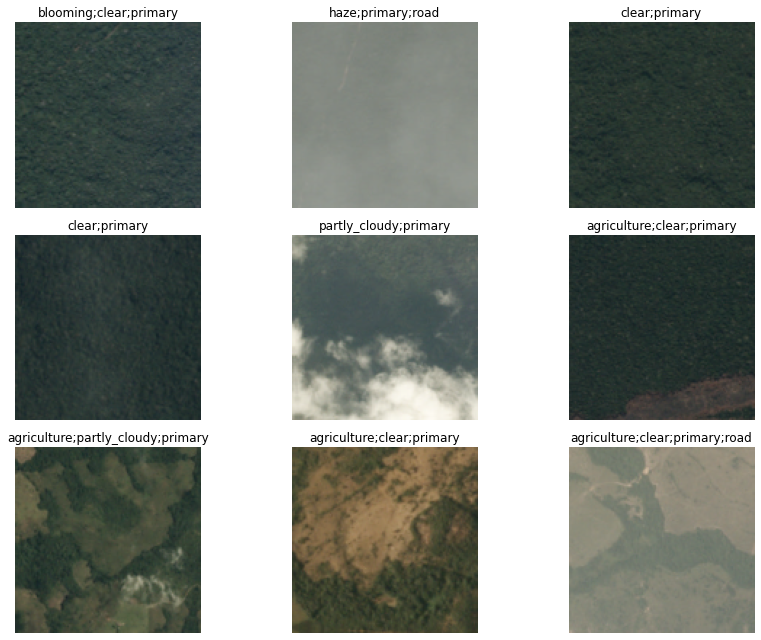

In [ ]:
data.show_batch(rows=3, figsize=(12, 9))

## Training

In [ ]:
acc_02 = partial(accuracy_thresh, thresh=0.2)
f_score = partial(fbeta, thresh=0.2)
learn = create_cnn(data, models.resnet50, metrics=[acc_02, f_score])

/usr/local/lib/python3.6/dist-packages/fastai/vision/learner.py:109: UserWarning: `create_cnn` is deprecated and is now named `cnn_learner`.
  warn("`create_cnn` is deprecated and is now named `cnn_learner`.")
Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


In [ ]:
learn

Learner(data=ImageDataBunch;

Train: LabelList (32384 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: MultiCategoryList
haze;primary,clear;primary,clear;primary,haze;primary;water,agriculture;clear;cultivation;primary;water
Path: /root/.fastai/data/planet/planet/planet;

Valid: LabelList (8095 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: MultiCategoryList
clear;primary;road,clear;primary;water,clear;conventional_mine;habitation;primary;road;water,cloudy,agriculture;clear;cultivation;cultivation;habitation;primary;road;water
Path: /root/.fastai/data/planet/planet/planet;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2

In [ ]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


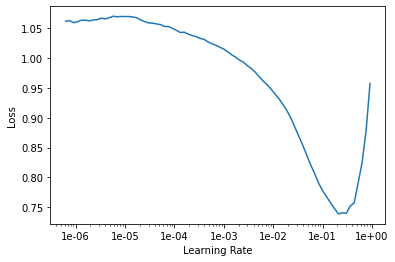

In [ ]:
learn.recorder.plot()

In [ ]:
lr = 0.01
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.138214,0.114670,0.943661,0.901002,03:46
1,0.112855,0.099981,0.948523,0.912225,03:46
2,0.101654,0.093864,0.954009,0.917615,03:45
3,0.094298,0.088671,0.956357,0.924913,03:46
4,0.092231,0.087615,0.956981,0.925111,03:45


In [ ]:
learn.save('planet-amazon-stage-1')

In [ ]:
learn.unfreeze()

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


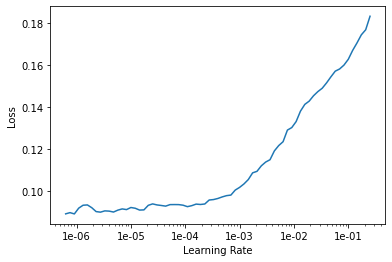

In [ ]:
learn.lr_find()
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(5, slice(1e-5, lr/5))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.096502,0.091131,0.953908,0.922668,04:34
1,0.095280,0.090754,0.951633,0.921200,04:34
2,0.092978,0.086505,0.955092,0.924498,04:34
3,0.084834,0.083943,0.958202,0.927808,04:34
4,0.080928,0.082955,0.958965,0.928325,04:35


In [ ]:
learn.save('planet-amazon-stage-2')

In [ ]:
# switch resolution
data = (src.transform(tfms, size=256)
        .databunch(bs=16).normalize(imagenet_stats))
learn.data = data
data.train_ds[0][0].shape

torch.Size([3, 256, 256])

In [ ]:
learn.freeze()

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


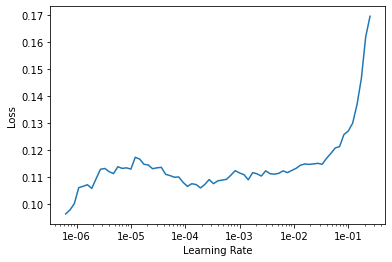

In [ ]:
learn.lr_find()
learn.recorder.plot()

In [ ]:
lr=1e-2/2
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.093056,0.090388,0.957628,0.923059,12:10
1,0.105988,0.089082,0.959880,0.925526,12:13
2,0.100279,0.092062,0.961247,0.925351,12:10
3,0.089158,0.084563,0.957700,0.927943,12:08
4,0.094781,0.084591,0.961174,0.928802,12:09


In [ ]:
learn.save('planet-amazon-stage-3')

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(5, slice(1e-5, lr/5))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.095430,0.096317,0.958601,0.925509,16:15
1,0.100576,0.090080,0.959902,0.925066,16:13
2,0.097027,0.100516,0.958173,0.924688,16:17
3,0.091246,0.093713,0.959895,0.927613,16:13
4,0.084253,0.094456,0.958958,0.927347,16:11


In [ ]:
learn.save('planet-amazon-stage-4')

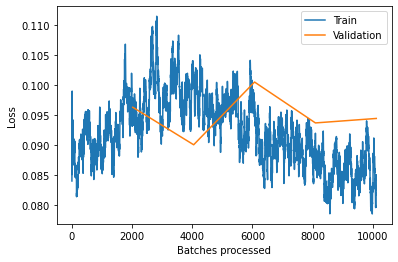

In [ ]:
learn.recorder.plot_losses()

In [ ]:
learn.export()